# Solving cartpole task with policy-based RL algorithms

**Decription of the task:**
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import gym
import agents

In [22]:
from importlib import reload
reload(agents)

<module 'agents' from '/home/nicola/Nicola_unipd/MasterThesis/Policy-based-RL/agents.py'>

In [295]:
def play_episode(agent, env, return_states=False):
    # Reset environment (start of an episode)
    state = env.reset()
    rewards = []
    log_probs = []
    
    if return_states:
        states = [state]
        
    steps = 0
    while True:
        action, log_prob = agent.get_action(state, return_log = True, greedy=False)
        new_state, reward, terminal, info = env.step(action) # gym standard step's output
        
        if return_states:
            states.append(new_state)
            
        if terminal and 'TimeLimit.truncated' not in info:
            reward = -1
            
        rewards.append(reward)
        log_probs.append(log_prob)
        
        if terminal:
            break
            
        state = new_state
       
    rewards = np.array(rewards)
    log_probs = np.array(log_probs)
    
    if return_states:
        return rewards, log_probs, np.array(states)
    else:
        return rewards, log_probs

In [296]:
def train_cartpole(n_episodes = 100, lr = 0.01, gamma = 0.99):
    # Create environment
    env = gym.make("CartPole-v1")
    observation_space = env.observation_space.shape[0]
    action_space = env.action_space.n
    # Init agent
    agent = agents.PolicyGrad(observation_space, action_space, lr, gamma)
    performance = []
    for e in range(n_episodes):
        rewards, log_probs = play_episode(agent, env)
        
        performance.append(np.sum(rewards))
        print("Episode %d - reward: %.0f"%(e+1, performance[-1]))
        
        agent.update(rewards, log_probs)
        
    return agent, np.array(performance)

In [111]:
%%time
trained_agent, cumulative_reward = train_cartpole(n_episodes = 200)

Episode 1 - reward: 16
Episode 2 - reward: 26
Episode 3 - reward: 10
Episode 4 - reward: 8
Episode 5 - reward: 37
Episode 6 - reward: 11
Episode 7 - reward: 13
Episode 8 - reward: 11
Episode 9 - reward: 23
Episode 10 - reward: 46
Episode 11 - reward: 14
Episode 12 - reward: 28
Episode 13 - reward: 17
Episode 14 - reward: 27
Episode 15 - reward: 66
Episode 16 - reward: 11
Episode 17 - reward: 27
Episode 18 - reward: 10
Episode 19 - reward: 13
Episode 20 - reward: 13
Episode 21 - reward: 18
Episode 22 - reward: 10
Episode 23 - reward: 18
Episode 24 - reward: 32
Episode 25 - reward: 15
Episode 26 - reward: 11
Episode 27 - reward: 31
Episode 28 - reward: 20
Episode 29 - reward: 43
Episode 30 - reward: 38
Episode 31 - reward: 33
Episode 32 - reward: 21
Episode 33 - reward: 11
Episode 34 - reward: 13
Episode 35 - reward: 76
Episode 36 - reward: 48
Episode 37 - reward: 38
Episode 38 - reward: 96
Episode 39 - reward: 61
Episode 40 - reward: 27
Episode 41 - reward: 12
Episode 42 - reward: 25
Ep

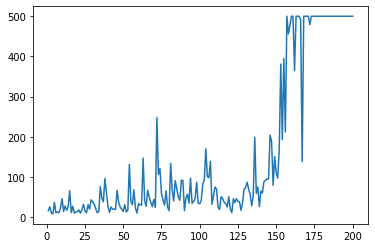

In [112]:
episodes = np.arange(1,len(cumulative_reward)+1)
plt.plot(episodes, cumulative_reward)

In [113]:
def render_test_episode(agent):
    # Create environment
    env = gym.make("CartPole-v1")
    observation_space = env.observation_space.shape[0]
    action_space = env.action_space.n
    state = env.reset()
    while True:
        env.render()
        action = agent.get_action(state, return_log = False, greedy=False)
        new_state, reward, terminal, info = env.step(action) # gym standard step's output
        if terminal: 
            break
        else: 
            state = new_state
    env.close()

In [114]:
render_test_episode(trained_agent) # shutdown kernel in case of problems

# Advantage Actor-Critic

In [364]:
from importlib import reload
reload(agents)

<module 'agents' from '/home/nicola/Nicola_unipd/MasterThesis/Policy-based-RL/agents.py'>

In [365]:
class experience_buffer():
    def __init__(self, r_list, logp_list, s_list):
        self.r_list = r_list
        self.logp_list = logp_list
        self.s_list = s_list
    
    def get_exp(self):
        L = np.min([len(r) for r in self.r_list])
        r_list_final = np.array([x[-L:] for x in self.r_list])
        logp_list_final = np.array([x[-L:] for x in self.logp_list])
        s_list_final = np.array([x[-L-1:] for x in self.s_list])
        return r_list_final, logp_list_final, s_list_final

In [366]:
def train_cartpole_A2C(n_epochs = 100, n_batches = 2, lr = 0.1, gamma = 0.99):
    # Create environment
    env = gym.make("CartPole-v1")
    observation_space = env.observation_space.shape[0]
    action_space = env.action_space.n
    # Init agent
    agent = agents.A2C(observation_space, action_space, lr, gamma)
    performance = []
    for e in range(n_epochs):
        r_list = []
        logp_list = []
        s_list = []
        score = []
        for b in range(n_batches):
            rewards, log_probs, states = play_episode(agent, env, return_states=True)
            r_list.append(rewards)
            logp_list.append(log_probs)
            s_list.append(states)
            score.append(np.sum(rewards))
        
        performance.append(np.mean(score))
        print("Epoch %d - mean reward: %.0f"%(e+1, performance[-1]))
        exp_buff = experience_buffer(r_list, logp_list, s_list)
        rewards, log_probs, states = exp_buff.get_exp()
        #print("rewards.shape ", rewards.shape)
        #print("log_probs.shape ", log_probs.shape)
        #print("states.shape ", states.shape)
        agent.update(rewards, log_probs, states)
        
    return agent, np.array(performance)

In [367]:
%%time
agent, performance = train_cartpole_A2C(n_epochs=100, lr=1e-2)

Epoch 1 - mean reward: 20
old_states  tensor([[[ 1.0477e-02,  1.1237e-02,  4.0789e-02, -2.3420e-02],
         [ 1.0701e-02, -1.8445e-01,  4.0320e-02,  2.8185e-01],
         [ 7.0124e-03, -3.8012e-01,  4.5957e-02,  5.8697e-01],
         [-5.8999e-04, -1.8567e-01,  5.7697e-02,  3.0911e-01],
         [-4.3034e-03,  8.5848e-03,  6.3879e-02,  3.5167e-02],
         [-4.1317e-03, -1.8739e-01,  6.4582e-02,  3.4730e-01],
         [-7.8795e-03, -3.8337e-01,  7.1528e-02,  6.5963e-01],
         [-1.5547e-02, -1.8931e-01,  8.4721e-02,  3.9030e-01],
         [-1.9333e-02,  4.5107e-03,  9.2527e-02,  1.2548e-01],
         [-1.9243e-02,  1.9819e-01,  9.5036e-02, -1.3663e-01],
         [-1.5279e-02,  3.9183e-01,  9.2304e-02, -3.9789e-01],
         [-7.4424e-03,  1.9553e-01,  8.4346e-02, -7.7588e-02],
         [-3.5318e-03, -6.9045e-04,  8.2794e-02,  2.4047e-01],
         [-3.5456e-03,  1.9316e-01,  8.7604e-02, -2.4993e-02],
         [ 3.1757e-04, -3.1047e-03,  8.7104e-02,  2.9399e-01],
         [ 2.5548

new_states  tensor([[[ 3.7519e-02, -1.7039e-01, -2.2905e-02,  2.5451e-01],
         [ 3.4112e-02, -3.6518e-01, -1.7815e-02,  5.3988e-01],
         [ 2.6808e-02, -5.6004e-01, -7.0178e-03,  8.2689e-01],
         [ 1.5607e-02, -7.5507e-01,  9.5201e-03,  1.1174e+00],
         [ 5.0579e-04, -9.5032e-01,  3.1867e-02,  1.4130e+00],
         [-1.8501e-02, -7.5560e-01,  6.0128e-02,  1.1305e+00],
         [-3.3613e-02, -9.5146e-01,  8.2737e-02,  1.4414e+00],
         [-5.2642e-02, -7.5745e-01,  1.1156e-01,  1.1757e+00],
         [-6.7791e-02, -9.5383e-01,  1.3508e-01,  1.5011e+00],
         [-8.6867e-02, -7.6058e-01,  1.6510e-01,  1.2535e+00],
         [-1.0208e-01, -9.5739e-01,  1.9017e-01,  1.5930e+00],
         [-1.2123e-01, -1.1542e+00,  2.2203e-01,  1.9385e+00]],

        [[ 2.9219e-02, -8.2621e-03, -1.2754e-01, -2.0408e-01],
         [ 2.9053e-02, -2.0135e-01, -1.3163e-01,  4.5806e-02],
         [ 2.5026e-02, -4.6115e-03, -1.3071e-01, -2.8534e-01],
         [ 2.4934e-02,  1.9211e-01, -1.36

Epoch 10 - mean reward: 22
old_states  tensor([[[-4.4912e-04,  7.7383e-03,  1.3400e-02,  1.8052e-02],
         [-2.9435e-04,  2.0267e-01,  1.3761e-02, -2.7037e-01],
         [ 3.7590e-03,  7.3500e-03,  8.3535e-03,  2.6618e-02],
         [ 3.9060e-03,  2.0235e-01,  8.8858e-03, -2.6342e-01],
         [ 7.9530e-03,  7.1035e-03,  3.6175e-03,  3.2054e-02],
         [ 8.0951e-03,  2.0217e-01,  4.2586e-03, -2.5948e-01],
         [ 1.2139e-02,  6.9909e-03, -9.3114e-04,  3.4538e-02],
         [ 1.2278e-02, -1.8812e-01, -2.4037e-04,  3.2693e-01],
         [ 8.5160e-03, -3.8324e-01,  6.2982e-03,  6.1953e-01],
         [ 8.5126e-04, -1.8820e-01,  1.8689e-02,  3.2884e-01],
         [-2.9128e-03,  6.6482e-03,  2.5266e-02,  4.2110e-02],
         [-2.7798e-03,  2.0140e-01,  2.6108e-02, -2.4250e-01],
         [ 1.2481e-03,  3.9614e-01,  2.1258e-02, -5.2683e-01],
         [ 9.1709e-03,  5.9095e-01,  1.0721e-02, -8.1274e-01],
         [ 2.0990e-02,  7.8593e-01, -5.5334e-03, -1.1020e+00],
         [ 3.670

loss  tensor(15., dtype=torch.float64, grad_fn=<MeanBackward0>)
V (actor)  tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       grad_fn=<SqueezeBackward0>)
Epoch 16 - mean reward: 22
old_states  tensor([[[-1.2777e-02,  2.1863e-01,  3.1731e-02, -2.9189e-01],
         [-8.4039e-03,  2.3073e-02,  2.5893e-02,  1.0631e-02],
         [-7.9424e-03, -1.7241e-01,  2.6106e-02,  3.1137e-01],
         [-1.1391e-02,  2.2330e-02,  3.2333e-02,  2.7033e-02],
         [-1.0944e-02,  2.1697e-01,  3.2874e-02, -2.5528e-01],
         [-6.6046e-03,  4.1161e-01,  2.7768e-02, -5.3741e-01],
         [ 1.6277e-03,  6.0633e-01,  1.7020e-02, -8.2122e-01],
         [ 1.3754e-02,  4.1098e-01,  5.9573e-04, -5.2323e-01],
         [ 2.1974e-02,  2.1585e-01, -9.8689e-03, -2.3036e-01],
         [ 2.6291e-02,  2.0871e-02, -1.4476e-02,  5.9195e-02],
         [ 2.6708e-02, -1.7404e-01, -1.3292e-02,  3.4728e-01],
         [ 2.3228

V (actor)  tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       grad_fn=<SqueezeBackward0>)
Epoch 21 - mean reward: 12
old_states  tensor([[[-0.0084, -0.3913,  0.0872,  0.7121],
         [-0.0162, -0.1975,  0.1014,  0.4481],
         [-0.0201, -0.3939,  0.1104,  0.7710],
         [-0.0280, -0.2004,  0.1258,  0.5150],
         [-0.0320, -0.3971,  0.1361,  0.8445],
         [-0.0400, -0.2040,  0.1530,  0.5976],
         [-0.0440, -0.0113,  0.1650,  0.3567],
         [-0.0443, -0.2084,  0.1721,  0.6965],
         [-0.0484, -0.4054,  0.1860,  1.0381],
         [-0.0565, -0.2132,  0.2068,  0.8091]],

        [[ 0.0304, -0.0497,  0.0368, -0.0436],
         [ 0.0294, -0.2454,  0.0359,  0.2604],
         [ 0.0245, -0.4410,  0.0411,  0.5642],
         [ 0.0156, -0.6366,  0.0524,  0.8696],
         [ 0.0029, -0.4423,  0.0698,  0.5938],
         [-0.0059, -0.6383,  0.0817,  0.9076],
         [-0.0187, -0.8344,  0.0998,  1.2248],
     

old_states  tensor([[[-5.8889e-03, -1.0720e-02, -1.0544e-02, -4.7812e-02],
         [-6.1033e-03,  1.8455e-01, -1.1500e-02, -3.4380e-01],
         [-2.4122e-03, -1.0405e-02, -1.8376e-02, -5.4769e-02],
         [-2.6203e-03,  1.8498e-01, -1.9471e-02, -3.5319e-01],
         [ 1.0792e-03, -9.8642e-03, -2.6535e-02, -6.6712e-02],
         [ 8.8188e-04,  1.8563e-01, -2.7869e-02, -3.6765e-01],
         [ 4.5944e-03,  3.8113e-01, -3.5222e-02, -6.6899e-01],
         [ 1.2217e-02,  5.7673e-01, -4.8602e-02, -9.7255e-01],
         [ 2.3752e-02,  7.7247e-01, -6.8053e-02, -1.2801e+00],
         [ 3.9201e-02,  5.7828e-01, -9.3655e-02, -1.0095e+00],
         [ 5.0767e-02,  7.7451e-01, -1.1384e-01, -1.3300e+00],
         [ 6.6257e-02,  9.7087e-01, -1.4045e-01, -1.6561e+00],
         [ 8.5674e-02,  7.7764e-01, -1.7357e-01, -1.4102e+00],
         [ 1.0123e-01,  9.7444e-01, -2.0177e-01, -1.7518e+00]],

        [[ 1.5479e-01,  9.5996e-01,  1.8861e-01, -3.3675e-01],
         [ 1.7399e-01,  1.1520e+00,  1.81

Epoch 31 - mean reward: 28
old_states  tensor([[[-5.5869e-02,  1.8155e-01,  1.5924e-01,  1.3287e-01],
         [-5.2238e-02, -1.5448e-02,  1.6190e-01,  4.7125e-01],
         [-5.2547e-02,  1.7706e-01,  1.7132e-01,  2.3366e-01],
         [-4.9006e-02,  3.6937e-01,  1.7600e-01, -4.6595e-04],
         [-4.1618e-02,  5.6159e-01,  1.7599e-01, -2.3286e-01],
         [-3.0387e-02,  7.5382e-01,  1.7133e-01, -4.6528e-01],
         [-1.5310e-02,  9.4616e-01,  1.6203e-01, -6.9944e-01],
         [ 3.6130e-03,  1.1387e+00,  1.4804e-01, -9.3705e-01],
         [ 2.6387e-02,  9.4193e-01,  1.2930e-01, -6.0175e-01],
         [ 4.5226e-02,  7.4526e-01,  1.1726e-01, -2.7130e-01],
         [ 6.0131e-02,  5.4868e-01,  1.1183e-01,  5.5942e-02],
         [ 7.1105e-02,  3.5215e-01,  1.1295e-01,  3.8171e-01],
         [ 7.8148e-02,  5.4550e-01,  1.2059e-01,  1.2667e-01],
         [ 8.9058e-02,  3.4888e-01,  1.2312e-01,  4.5483e-01],
         [ 9.6035e-02,  5.4206e-01,  1.3222e-01,  2.0335e-01],
         [ 1.068

old_states  tensor([[[-0.0277, -0.0233, -0.0056,  0.0459],
         [-0.0282, -0.2184, -0.0047,  0.3368],
         [-0.0325, -0.4134,  0.0021,  0.6281],
         [-0.0408, -0.2183,  0.0146,  0.3360],
         [-0.0452, -0.0234,  0.0213,  0.0480],
         [-0.0456,  0.1714,  0.0223, -0.2379],
         [-0.0422,  0.3662,  0.0176, -0.5234],
         [-0.0349,  0.1708,  0.0071, -0.2253],
         [-0.0315, -0.0244,  0.0026,  0.0696],
         [-0.0320, -0.2195,  0.0040,  0.3631],
         [-0.0363, -0.0245,  0.0112,  0.0717],
         [-0.0368, -0.2198,  0.0127,  0.3679],
         [-0.0412, -0.4151,  0.0200,  0.6645],
         [-0.0495, -0.2202,  0.0333,  0.3782],
         [-0.0539, -0.4158,  0.0409,  0.6812],
         [-0.0623, -0.6115,  0.0545,  0.9865],
         [-0.0745, -0.8073,  0.0742,  1.2958],
         [-0.0906, -0.6132,  0.1001,  1.0272],
         [-0.1029, -0.8095,  0.1207,  1.3496],
         [-0.1191, -1.0059,  0.1477,  1.6775],
         [-0.1392, -1.2024,  0.1812,  2.0123]],


new_states  tensor([[[ 7.4922e-03, -1.6732e-01, -3.7359e-04,  1.0593e-01],
         [ 4.1457e-03,  2.7805e-02,  1.7451e-03, -1.8687e-01],
         [ 4.7018e-03,  2.2290e-01, -1.9922e-03, -4.7900e-01],
         [ 9.1599e-03,  2.7809e-02, -1.1572e-02, -1.8694e-01],
         [ 9.7161e-03, -1.6715e-01, -1.5311e-02,  1.0207e-01],
         [ 6.3731e-03,  2.8192e-02, -1.3270e-02, -1.9541e-01],
         [ 6.9370e-03,  2.2350e-01, -1.7178e-02, -4.9225e-01],
         [ 1.1407e-02,  2.8626e-02, -2.7023e-02, -2.0503e-01],
         [ 1.1980e-02, -1.6610e-01, -3.1123e-02,  7.9011e-02],
         [ 8.6575e-03,  2.9455e-02, -2.9543e-02, -2.2333e-01],
         [ 9.2466e-03,  2.2499e-01, -3.4010e-02, -5.2518e-01],
         [ 1.3746e-02,  3.0359e-02, -4.4513e-02, -2.4341e-01],
         [ 1.4354e-02,  2.2609e-01, -4.9381e-02, -5.4979e-01],
         [ 1.8875e-02,  3.1693e-02, -6.0377e-02, -2.7307e-01],
         [ 1.9509e-02,  2.2762e-01, -6.5839e-02, -5.8416e-01],
         [ 2.4062e-02,  4.2360e-01, -7.7522

Epoch 45 - mean reward: 34
old_states  tensor([[[ 2.4780e-02,  2.2666e-01, -2.4758e-02, -2.9676e-01],
         [ 2.9313e-02,  3.1898e-02, -3.0694e-02, -1.1988e-02],
         [ 2.9951e-02,  2.2745e-01, -3.0933e-02, -3.1419e-01],
         [ 3.4500e-02,  3.2779e-02, -3.7217e-02, -3.1425e-02],
         [ 3.5156e-02,  2.2841e-01, -3.7846e-02, -3.3561e-01],
         [ 3.9724e-02,  3.3851e-02, -4.4558e-02, -5.5102e-02],
         [ 4.0401e-02, -1.6061e-01, -4.5660e-02,  2.2320e-01],
         [ 3.7189e-02,  3.5139e-02, -4.1196e-02, -8.3533e-02],
         [ 3.7891e-02, -1.5937e-01, -4.2867e-02,  1.9587e-01],
         [ 3.4704e-02,  3.6339e-02, -3.8949e-02, -1.1002e-01],
         [ 3.5431e-02, -1.5820e-01, -4.1150e-02,  1.7013e-01],
         [ 3.2267e-02,  3.7482e-02, -3.7747e-02, -1.3525e-01],
         [ 3.3016e-02,  2.3312e-01, -4.0452e-02, -4.3960e-01],
         [ 3.7679e-02,  3.8597e-02, -4.9244e-02, -1.5994e-01],
         [ 3.8451e-02, -1.5579e-01, -5.2443e-02,  1.1681e-01],
         [ 3.533

old_states  tensor([[[ 1.6898e-01,  3.7686e-02, -8.0840e-02,  1.1746e-01],
         [ 1.6973e-01, -1.5619e-01, -7.8491e-02,  3.8358e-01],
         [ 1.6661e-01,  3.9954e-02, -7.0819e-02,  6.7218e-02],
         [ 1.6741e-01, -1.5409e-01, -6.9475e-02,  3.3674e-01],
         [ 1.6433e-01,  4.1953e-02, -6.2740e-02,  2.2986e-02],
         [ 1.6517e-01,  2.3792e-01, -6.2280e-02, -2.8881e-01],
         [ 1.6992e-01,  4.3735e-02, -6.8057e-02, -1.6405e-02],
         [ 1.7080e-01,  2.3976e-01, -6.8385e-02, -3.2976e-01],
         [ 1.7559e-01,  4.3579e-01, -7.4980e-02, -6.4320e-01],
         [ 1.8431e-01,  2.4179e-01, -8.7844e-02, -3.7504e-01],
         [ 1.8915e-01,  4.8016e-02, -9.5345e-02, -1.1130e-01],
         [ 1.9011e-01, -1.4562e-01, -9.7571e-02,  1.4985e-01],
         [ 1.8719e-01,  5.0754e-02, -9.4574e-02, -1.7195e-01],
         [ 1.8821e-01, -1.4290e-01, -9.8013e-02,  8.9463e-02],
         [ 1.8535e-01, -3.3649e-01, -9.6223e-02,  3.4969e-01],
         [ 1.7862e-01, -5.3012e-01, -8.9230

old_states  tensor([[[ 5.1230e-03,  3.3969e-02,  4.2264e-02, -3.5304e-03],
         [ 5.8023e-03,  2.2846e-01,  4.2194e-02, -2.8258e-01],
         [ 1.0372e-02,  3.2762e-02,  3.6542e-02,  2.3102e-02],
         [ 1.1027e-02,  2.2734e-01,  3.7004e-02, -2.5783e-01],
         [ 1.5574e-02,  3.1712e-02,  3.1848e-02,  4.6290e-02],
         [ 1.6208e-02,  2.2636e-01,  3.2773e-02, -2.3618e-01],
         [ 2.0735e-02,  3.0788e-02,  2.8050e-02,  6.6661e-02],
         [ 2.1351e-02,  2.2550e-01,  2.9383e-02, -2.1704e-01],
         [ 2.5861e-02,  2.9968e-02,  2.5042e-02,  8.4763e-02],
         [ 2.6460e-02, -1.6550e-01,  2.6737e-02,  3.8524e-01],
         [ 2.3150e-02,  2.9228e-02,  3.4442e-02,  1.0111e-01],
         [ 2.3735e-02,  2.2384e-01,  3.6464e-02, -1.8051e-01],
         [ 2.8211e-02,  4.1842e-01,  3.2854e-02, -4.6148e-01],
         [ 3.6580e-02,  2.2285e-01,  2.3625e-02, -1.5862e-01],
         [ 4.1037e-02,  2.7399e-02,  2.0452e-02,  1.4142e-01],
         [ 4.1585e-02, -1.6801e-01,  2.3281

Epoch 60 - mean reward: 18
old_states  tensor([[[ 0.0128,  0.3441, -0.0811, -0.6848],
         [ 0.0196,  0.1502, -0.0947, -0.4187],
         [ 0.0226, -0.0435, -0.1031, -0.1573],
         [ 0.0218,  0.1529, -0.1063, -0.4807],
         [ 0.0248, -0.0405, -0.1159, -0.2233],
         [ 0.0240,  0.1560, -0.1204, -0.5502],
         [ 0.0271,  0.3526, -0.1314, -0.8782],
         [ 0.0342,  0.1595, -0.1489, -0.6296],
         [ 0.0374,  0.3564, -0.1615, -0.9652],
         [ 0.0445,  0.1637, -0.1808, -0.7273],
         [ 0.0478, -0.0285, -0.1954, -0.4965],
         [ 0.0472,  0.1688, -0.2053, -0.8439]],

        [[ 0.0445, -0.0070, -0.0316, -0.0466],
         [ 0.0443,  0.1886, -0.0325, -0.3491],
         [ 0.0481, -0.0061, -0.0395, -0.0669],
         [ 0.0480,  0.1896, -0.0409, -0.3718],
         [ 0.0518,  0.3853, -0.0483, -0.6770],
         [ 0.0595,  0.5810, -0.0618, -0.9845],
         [ 0.0711,  0.7769, -0.0815, -1.2960],
         [ 0.0866,  0.9730, -0.1074, -1.6130],
         [ 0.1061, 

V (actor)  tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       grad_fn=<SqueezeBackward0>)
Epoch 66 - mean reward: 38
old_states  tensor([[[ 2.5081e-02,  3.3885e-02, -5.4754e-02, -7.4686e-02],
         [ 2.5759e-02, -1.6041e-01, -5.6248e-02,  2.0023e-01],
         [ 2.2550e-02,  3.5468e-02, -5.2243e-02, -1.0965e-01],
         [ 2.3260e-02,  2.3130e-01, -5.4436e-02, -4.1835e-01],
         [ 2.7886e-02,  3.6988e-02, -6.2803e-02, -1.4331e-01],
         [ 2.8626e-02,  2.3295e-01, -6.5669e-02, -4.5513e-01],
         [ 3.3285e-02,  3.8816e-02, -7.4772e-02, -1.8384e-01],
         [ 3.4061e-02,  2.3492e-01, -7.8449e-02, -4.9915e-01],
         [ 3.8759e-02,  4.3106e-01, -8.8432e-02, -8.1549e-01],
         [ 4.7381e-02,  2.3725e-01, -1.0474e-01, -5.5188e-01],
         [ 5.2126e-02,  4.3368e-01, -1.1578e-01, -8.7564e-01],
         [ 6.0799e-02,  2.4030e-01, -1.3329e-01, -6.2148e-01],
  

new_states  tensor([[[ 2.5194e-02, -1.6225e-01, -1.7715e-02,  2.5593e-01],
         [ 2.1949e-02, -3.5711e-01, -1.2597e-02,  5.4297e-01],
         [ 1.4807e-02, -5.5205e-01, -1.7372e-03,  8.3166e-01],
         [ 3.7662e-03, -7.4715e-01,  1.4896e-02,  1.1238e+00],
         [-1.1177e-02, -9.4247e-01,  3.7372e-02,  1.4211e+00],
         [-3.0026e-02, -7.4783e-01,  6.5794e-02,  1.1403e+00],
         [-4.4983e-02, -9.4374e-01,  8.8601e-02,  1.4529e+00],
         [-6.3858e-02, -7.4981e-01,  1.1766e-01,  1.1892e+00],
         [-7.8854e-02, -5.5640e-01,  1.4144e-01,  9.3557e-01],
         [-8.9982e-02, -3.6344e-01,  1.6015e-01,  6.9046e-01],
         [-9.7250e-02, -1.7086e-01,  1.7396e-01,  4.5217e-01],
         [-1.0067e-01, -3.6796e-01,  1.8301e-01,  7.9425e-01],
         [-1.0803e-01, -1.7575e-01,  1.9889e-01,  5.6427e-01],
         [-1.1154e-01,  1.6103e-02,  2.1018e-01,  3.4024e-01]],

        [[ 2.8081e-02,  3.4379e-01,  3.0478e-02, -6.0155e-01],
         [ 3.4957e-02,  1.4825e-01,  1.84

old_states  tensor([[[-9.8202e-02, -5.7382e-02,  1.3785e-01,  1.9399e-01],
         [-9.9349e-02,  1.3553e-01,  1.4173e-01, -5.2225e-02],
         [-9.6639e-02,  3.2836e-01,  1.4068e-01, -2.9705e-01],
         [-9.0071e-02,  1.3154e-01,  1.3474e-01,  3.6485e-02],
         [-8.7441e-02, -6.5227e-02,  1.3547e-01,  3.6846e-01],
         [-8.8745e-02,  1.2774e-01,  1.4284e-01,  1.2137e-01],
         [-8.6190e-02, -6.9113e-02,  1.4527e-01,  4.5549e-01],
         [-8.7573e-02,  1.2369e-01,  1.5438e-01,  2.1190e-01],
         [-8.5099e-02, -7.3265e-02,  1.5862e-01,  5.4902e-01],
         [-8.6564e-02, -2.7022e-01,  1.6960e-01,  8.8718e-01],
         [-9.1969e-02, -7.7753e-02,  1.8734e-01,  6.5225e-01],
         [-9.3524e-02,  1.1433e-01,  2.0038e-01,  4.2391e-01],
         [-9.1237e-02,  3.0614e-01,  2.0886e-01,  2.0048e-01]],

        [[-2.2813e-02,  2.3361e-02,  9.3109e-03, -3.8529e-02],
         [-2.2346e-02,  2.1835e-01,  8.5403e-03, -3.2826e-01],
         [-1.7979e-02,  2.3105e-02,  1.97

Epoch 80 - mean reward: 16
old_states  tensor([[[ 3.1206e-02, -1.6108e-01,  2.3878e-02,  3.2285e-01],
         [ 2.7984e-02, -3.5653e-01,  3.0335e-02,  6.2297e-01],
         [ 2.0854e-02, -1.6185e-01,  4.2795e-02,  3.3999e-01],
         [ 1.7617e-02,  3.2640e-02,  4.9595e-02,  6.1105e-02],
         [ 1.8270e-02, -1.6316e-01,  5.0817e-02,  3.6901e-01],
         [ 1.5006e-02, -3.5896e-01,  5.8197e-02,  6.7728e-01],
         [ 7.8272e-03, -1.6469e-01,  7.1742e-02,  4.0347e-01],
         [ 4.5333e-03, -3.6076e-01,  7.9812e-02,  7.1788e-01],
         [-2.6819e-03, -5.5689e-01,  9.4169e-02,  1.0346e+00],
         [-1.3820e-02, -7.5313e-01,  1.1486e-01,  1.3553e+00],
         [-2.8882e-02, -5.5962e-01,  1.4197e-01,  1.1006e+00],
         [-4.0075e-02, -7.5629e-01,  1.6398e-01,  1.4343e+00],
         [-5.5200e-02, -5.6353e-01,  1.9266e-01,  1.1970e+00]],

        [[-2.9589e-02,  6.2283e-03, -1.9604e-02, -4.9310e-02],
         [-2.9465e-02, -1.8861e-01, -2.0590e-02,  2.3712e-01],
         [-3.3

Epoch 86 - mean reward: 58
old_states  tensor([[[-2.8822e-01, -2.1873e-01, -6.3032e-03, -7.4072e-02],
         [-2.9260e-01, -4.1376e-01, -7.7846e-03,  2.1662e-01],
         [-3.0087e-01, -2.1852e-01, -3.4523e-03, -7.8513e-02],
         [-3.0524e-01, -2.3353e-02, -5.0226e-03, -3.7228e-01],
         [-3.0571e-01, -2.1840e-01, -1.2468e-02, -8.1188e-02],
         [-3.1008e-01, -2.3105e-02, -1.4092e-02, -3.7778e-01],
         [-3.1054e-01, -2.1802e-01, -2.1648e-02, -8.9572e-02],
         [-3.1490e-01, -2.2599e-02, -2.3439e-02, -3.8901e-01],
         [-3.1535e-01, -2.1738e-01, -3.1219e-02, -1.0380e-01],
         [-3.1970e-01, -2.1825e-02, -3.3295e-02, -4.0617e-01],
         [-3.2014e-01, -2.1646e-01, -4.1419e-02, -1.2417e-01],
         [-3.2447e-01, -2.0769e-02, -4.3902e-02, -4.2962e-01],
         [-3.2488e-01,  1.7495e-01, -5.2495e-02, -7.3582e-01],
         [-3.2138e-01, -1.9413e-02, -6.7211e-02, -4.6011e-01],
         [-3.2177e-01, -2.1352e-01, -7.6413e-02, -1.8934e-01],
         [-3.260

Epoch 91 - mean reward: 18
old_states  tensor([[[ 1.0941e-02,  1.3460e-02, -7.9180e-06, -5.4201e-03],
         [ 1.1210e-02, -1.8166e-01, -1.1632e-04,  2.8726e-01],
         [ 7.5767e-03,  1.3462e-02,  5.6289e-03, -5.4593e-03],
         [ 7.8460e-03, -1.8174e-01,  5.5197e-03,  2.8899e-01],
         [ 4.2112e-03, -3.7694e-01,  1.1300e-02,  5.8341e-01],
         [-3.3276e-03, -5.7222e-01,  2.2968e-02,  8.7963e-01],
         [-1.4772e-02, -7.6765e-01,  4.0561e-02,  1.1794e+00],
         [-3.0125e-02, -5.7307e-01,  6.4149e-02,  8.9975e-01],
         [-4.1586e-02, -3.7888e-01,  8.2145e-02,  6.2790e-01],
         [-4.9164e-02, -5.7504e-01,  9.4703e-02,  9.4528e-01],
         [-6.0665e-02, -3.8132e-01,  1.1361e-01,  6.8379e-01],
         [-6.8291e-02, -1.8794e-01,  1.2728e-01,  4.2893e-01],
         [-7.2050e-02, -3.8461e-01,  1.3586e-01,  7.5887e-01],
         [-7.9742e-02, -1.9160e-01,  1.5104e-01,  5.1184e-01],
         [-8.3574e-02,  1.1105e-03,  1.6128e-01,  2.7031e-01],
         [-8.355

new_states  tensor([[[-2.0527e-03,  1.9531e-01, -1.4831e-02, -2.8192e-01],
         [ 1.8536e-03,  4.0594e-04, -2.0469e-02,  6.0531e-03],
         [ 1.8617e-03, -1.9442e-01, -2.0348e-02,  2.9221e-01],
         [-2.0266e-03, -3.8924e-01, -1.4504e-02,  5.7840e-01],
         [-9.8115e-03, -1.9392e-01, -2.9360e-03,  2.8119e-01],
         [-1.3690e-02,  1.2433e-03,  2.6878e-03, -1.2419e-02],
         [-1.3665e-02,  1.9633e-01,  2.4394e-03, -3.0425e-01],
         [-9.7385e-03,  3.9141e-01, -3.6457e-03, -5.9617e-01],
         [-1.9102e-03,  1.9634e-01, -1.5569e-02, -3.0463e-01],
         [ 2.0167e-03,  3.9168e-01, -2.1662e-02, -6.0219e-01],
         [ 9.8503e-03,  5.8710e-01, -3.3705e-02, -9.0161e-01],
         [ 2.1592e-02,  3.9245e-01, -5.1738e-02, -6.1971e-01],
         [ 2.9441e-02,  1.9809e-01, -6.4132e-02, -3.4376e-01],
         [ 3.3403e-02,  3.9356e-03, -7.1007e-02, -7.1971e-02],
         [ 3.3482e-02, -1.9010e-01, -7.2447e-02,  1.9749e-01],
         [ 2.9680e-02,  5.9791e-03, -6.8497

In [309]:
help(np.cumsum)

Help on function cumsum in module numpy:

cumsum(a, axis=None, dtype=None, out=None)
    Return the cumulative sum of the elements along a given axis.
    
    Parameters
    ----------
    a : array_like
        Input array.
    axis : int, optional
        Axis along which the cumulative sum is computed. The default
        (None) is to compute the cumsum over the flattened array.
    dtype : dtype, optional
        Type of the returned array and of the accumulator in which the
        elements are summed.  If `dtype` is not specified, it defaults
        to the dtype of `a`, unless `a` has an integer dtype with a
        precision less than that of the default platform integer.  In
        that case, the default platform integer is used.
    out : ndarray, optional
        Alternative output array in which to place the result. It must
        have the same shape and buffer length as the expected output
        but the type will be cast if necessary. See `doc.ufuncs`
        (Section

In [359]:
list(agent.critic.parameters())

[Parameter containing:
 tensor([[-0.1263,  0.3866,  0.0456,  0.3643],
         [-0.2736,  0.0180, -0.0637, -0.1833],
         [ 0.0846,  0.1753, -0.3218,  0.0452],
         [-0.2278,  0.1654, -0.1308,  0.0906],
         [ 0.2719, -0.3647,  0.4994,  0.3115],
         [ 0.1629, -0.0067, -0.2834, -0.0048],
         [-0.3885, -0.0364,  0.3563, -0.3547],
         [-0.4958,  0.2375,  0.3806,  0.4823]], requires_grad=True),
 Parameter containing:
 tensor([-0.0949,  0.2466,  0.4672, -0.1669,  0.1722,  0.5263, -0.3237, -0.2327],
        requires_grad=True),
 Parameter containing:
 tensor([[-0.1548,  0.2393, -0.3896, -0.2432,  0.1124, -0.3969,  0.1244, -0.2267]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.1159], requires_grad=True)]